In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from string import punctuation
import re

from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D

## Load Data

In [2]:
train = pd.read_csv("train.tsv", sep='\t', usecols=['Phrase', 'Sentiment']);
train.head(3)

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2


In [3]:
# values in target
print(f"Unique values in target: {train['Sentiment'].unique()}")

Unique values in target: [1 2 3 4 0]


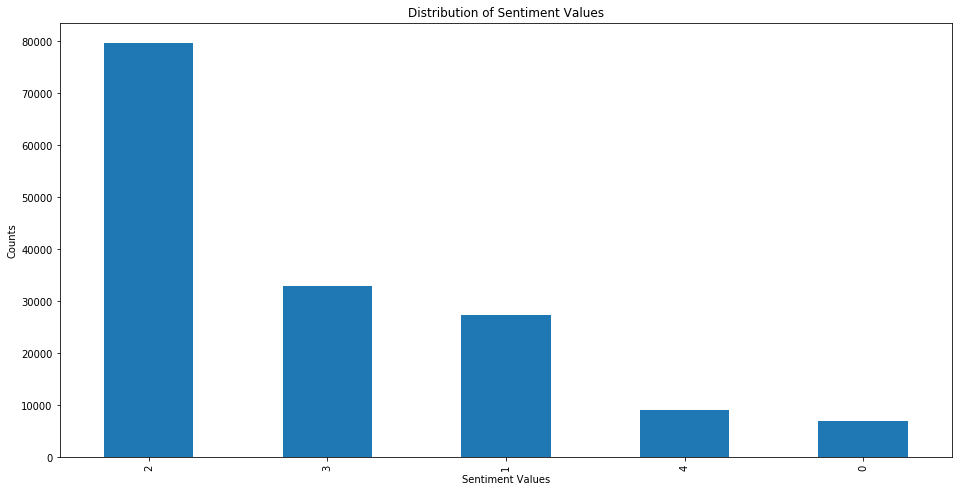

In [4]:
plt.figure(figsize=(16,8))
train.Sentiment.value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment Values')
plt.xlabel('Sentiment Values')
plt.ylabel('Counts');


In [5]:
test = pd.read_csv("test.tsv", sep='\t', usecols=['Phrase']);
# filling the pseudo-target value in test data 
test['Sentiment']= 9 
test.head(3)

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,9
1,An intermittently pleasing but mostly routine ...,9
2,An,9


In [6]:
# Combine train and test as a first step to clean the data
df = pd.concat([train, test], ignore_index=True)
df.tail()

,Phrase,Sentiment
222347,"A long-winded , predictable scenario .",9
222348,"A long-winded , predictable scenario",9
222349,"A long-winded ,",9
222350,A long-winded,9
222351,predictable scenario,9


In [7]:
def clean_text(text):
    lemma = WordNetLemmatizer()
    text_corpus = []
    for sentence in text:
        sentence=re.sub('[^a-zA-Z]',' ',sentence)
        sentence=[lemma.lemmatize(w) for w in word_tokenize(sentence.lower())]
        sentence = ' '.join(sentence)
        text_corpus.append(sentence)      
    return text_corpus        

In [8]:
df['cleaned_Phrase'] = clean_text(df.Phrase)

### Separate the train and test set 

In [9]:
df_train = df[df.Sentiment != 9]
df_train.shape, train.shape

((156060, 3), (156060, 2))

In [10]:
df_train.head(3)

,Phrase,Sentiment,cleaned_Phrase
0,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,A series,2,a series


In [11]:
df_test = df[df.Sentiment == 9]
df_test.drop('Sentiment', axis=1, inplace=True)
df_test.shape, test.shape

C:\Users\macik\.conda\envs\deeplearning\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((66292, 2), (66292, 2))

In [12]:
df_test.head(3)

,Phrase,cleaned_Phrase
156060,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
156061,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
156062,An,an


## Splitting Train dataset into train and 20% validation set


In [13]:
train_text = df_train.cleaned_Phrase
test_text = df_test.cleaned_Phrase
target = df_train.Sentiment
y = to_categorical(target)
print(train_text.shape,target.shape,y.shape)
#print(y)

(156060,) (156060,) (156060, 5)


In [14]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


### Finding number of unique words in train set

In [15]:
from collections import Counter

all_words = ' '.join(X_train_text)
all_words = word_tokenize(all_words)
num_unique_word = len(Counter(all_words).keys())
print(f'Number of unique words : {num_unique_word}')

Number of unique words : 13732


### Finding max length of a phrase in train set (longest text in train set)

In [16]:
longest_text_length = 0
for text in X_train_text:
    word=word_tokenize(text)
    if len(word) > longest_text_length:
        longest_text_length = len(word)
    
print(f'longest text length in train set: {longest_text_length}')

longest text length in train set: 48


## Preprocessing text

In [17]:
# Defaults
max_features = num_unique_word
max_words = longest_text_length
batch_size = 128
epochs = 10
# num_classes=len(train.Sentiment.unique())  // 5
num_classes =  len(train.Sentiment.value_counts())
# len(train.Sentiment.unique())
num_classes

5

In [18]:
# Tokenize and transform to integer index
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_text)

X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

# Add pading to ensure all vectors have same dimensionality
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


## CNN

In [19]:
embedding_dim = 100
model= Sequential()
model.add(Embedding(max_features,embedding_dim,input_length=max_words))
model.add(Dropout(0.2))
model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           1373200   
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 64)            19264     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

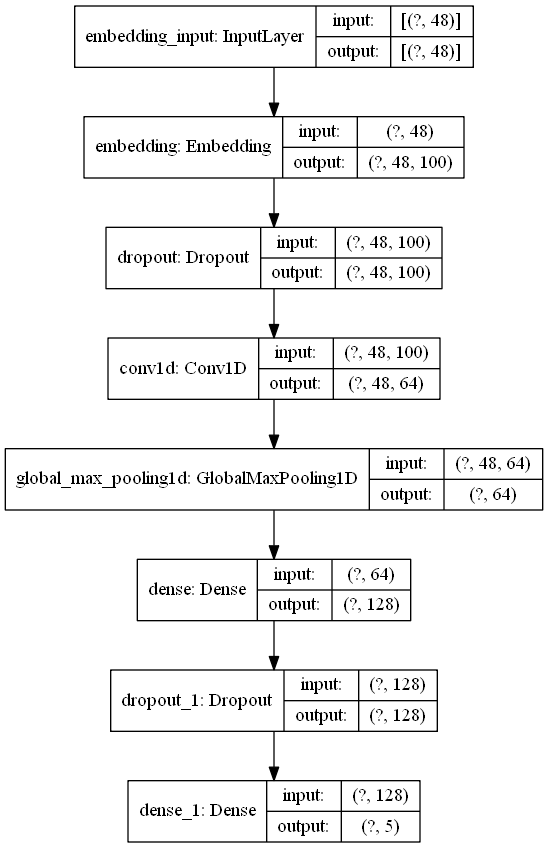

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [21]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/10
976/976 [==============================] - 69s 71ms/step - loss: 1.0076 - accuracy: 0.5978 - val_loss: 0.8449 - val_accuracy: 0.6508
Epoch 2/10
976/976 [==============================] - 71s 73ms/step - loss: 0.7854 - accuracy: 0.6773 - val_loss: 0.8174 - val_accuracy: 0.6611
Epoch 3/10
976/976 [==============================] - 68s 70ms/step - loss: 0.7034 - accuracy: 0.7071 - val_loss: 0.8026 - val_accuracy: 0.6648
Epoch 4/10
976/976 [==============================] - 66s 68ms/step - loss: 0.6477 - accuracy: 0.7291 - val_loss: 0.8201 - val_accuracy: 0.6622
Epoch 5/10
976/976 [==============================] - 65s 67ms/step - loss: 0.6044 - accuracy: 0.7453 - val_loss: 0.8276 - val_accuracy: 0.6633
Epoch 6/10
976/976 [==============================] - 67s 69ms/step - loss: 0.5698 - accuracy: 0.7579 - val_loss: 0.8675 - val_accuracy: 0.6612
Epoch 7/10
976/976 [==============================] - 65s 67ms/step - loss: 0.5409 - accuracy: 0.7683 - val_loss: 0.8951 - val_accuracy:

### Save Model for reusability

In [22]:
# from keras.models import load_model
model.save('my_model_2.h5')
# model_load = load_model('my_model.h5')

### Plot model accuracy and loss

In [23]:
def plot_history(history):
    plt.style.use('ggplot')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

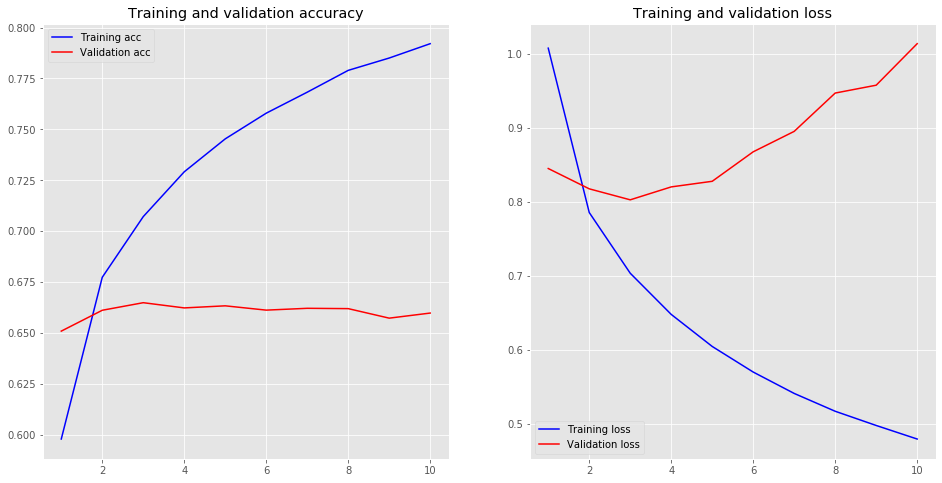

In [24]:
plot_history(history)

### Model Evaluation

In [25]:
scores = model.evaluate(X_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

976/976 [==============================] - 2s 2ms/step - loss: 1.0137 - accuracy: 0.6597
Test loss: 1.0136590003967285
Test accuracy: 0.6597142219543457


In [26]:
scores = model.evaluate(X_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

3902/3902 [==============================] - 9s 2ms/step - loss: 0.3753 - accuracy: 0.8464
Train loss: 0.3753078281879425
Train accuracy: 0.8463732004165649


### Prediction

In [27]:
X_sample = ['this is a terrific movie']
X_sample = tokenizer.texts_to_sequences(X_sample)
X_sample = sequence.pad_sequences(X_sample, maxlen=max_words)

y_sample = model.predict_classes(X_sample).flatten().tolist()

print('Prediction: ',y_sample)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Prediction:  [4]
